# LAB 7: Error analysis

Objectives
* Construct a  linear text classifier using SGDClassifier
* Evaluate its performance and categorize the errors that it makes
* Eaxmine model's coefficients and decision function values
* Interpret model results using LIME

In [1]:
import numpy as np
import pandas as pd
from cytoolz import *
from tqdm.auto import tqdm

tqdm.pandas()

---

## Load data

In [2]:
train = pd.read_parquet("s3://ling583/lab7-train.parquet", storage_options={"anon":True})
test = pd.read_parquet("s3://ling583/lab7-test.parquet", storage_options={"anon":True})

In [3]:
import cloudpickle
from sklearn.metrics import classification_report, f1_score, plot_confusion_matrix

In [4]:
sgd = cloudpickle.load(open("sgd.model", "rb"))

In [5]:
predicted = sgd.predict(test["text"])
print(classification_report(test["topics"], predicted))

              precision    recall  f1-score   support

        GJOB       0.97      0.94      0.95       573
        GPOL       0.94      0.97      0.95      1853
        GSPO       1.00      0.99      1.00      1410
        GVIO       0.93      0.90      0.91       928

    accuracy                           0.96      4764
   macro avg       0.96      0.95      0.95      4764
weighted avg       0.96      0.96      0.96      4764



---

## Decision function

In [6]:
labels = sgd.named_steps['sgdclassifier'].classes_
scores = sgd.decision_function(test["text"])

In [7]:
labels

array(['GJOB', 'GPOL', 'GSPO', 'GVIO'], dtype='<U4')

In [8]:
scores[0,:]

array([ 0.00943159, -0.82207324, -1.01042548, -0.94383252])

In [9]:
test['topics'].iloc[0]

'GJOB'

In [10]:
test['text'].iloc[0]

"Canada's Terra Nova partners set labor agreement. A new labor agreement covering future operations at Newfoundland's Bull Arm construction site, where some work on the Terra Nova oil project is expected to be done, was completed on Monday, Terra Nova's partners said. The deal, signed by PCL Industrial Constructors Inc and the Newfoundland and Labrador Building and Construction Trades Council, will allow Bull Arm to be considered for the building of some of the oil platform's topsides. The key part of the deal was the formation of a single union representing workers at the site, the firms said."

In [11]:
highest = scores.max(axis=1)

In [12]:
highest[0]

0.00943158575712999

In [13]:
highest.argmax()

3436

In [19]:
scores[3436]

array([-2.94796285,  4.87591194, -2.50605886, -3.93026551])

In [20]:
test['topics'].iloc[3436]

'GPOL'

In [21]:
test['text'].iloc[3436]

"FRENCH ELECTION - HOW THEY VOTE. About 39 million French voters are entitled to vote in Sunday's first round of a two-stage election to choose a new National Assembly or lower house of parliament. President Jacques Chirac used his constitutional power to dissolve the Assembly on April 21 and called a snap election, 10 months ahead of schedule, for May 25 and June 1. The president, who appoints the prime minister and cabinet, may not dissolve parliament again in the first year of a new legislature. Some 6,389 candidates are vying for the 577 seats in single-member constituencies, the Interior Ministry said. The record is 29 candidates in a single electoral district in central Paris. A candidate who wins more than 50 percent of votes cast on the first ballot is elected without a runoff. Otherwise, any candidate who polls 12.5 percent of the total of registered voters has the right to contest the second ballot. The person who wins the most votes on the runoff is elected, even if he or sh

In [18]:
highest.argmin()

1824

In [22]:
scores[1824]

array([-0.73942135, -0.5082602 , -0.89284713, -0.66066142])

In [23]:
test['topics'].iloc[1824]

'GPOL'

In [24]:
test['text'].iloc[1824]

'KKK says membership is growing in the United States. The Ku Klux Klan\'s membership drive has successfully crossed the Mason-Dixon Line and is now concentrating on building membership through the nation\'s prison population, Klan leaders said on Saturday. Speaking before a rally in Pittsburgh, the Klan\'s top two national officers denied that the organisation\'s strongholds were limited to the Deep South, as typically perceived, adding that Texas was the next target for major Klan recruitment. "That (strength limited to the South) is something the media tries to portray," said Jeff Berry, Imperial Wizard of the Klan. "Indiana always has been the strongest state for the Klan. We\'ve had rallies in Indiana where our membership numbered 300,000 strong." Berry, who claimed his position in the Klan was akin to being president of the United States, said membership in Indiana numbers around 8,000. He would not disclose totals from other states, but said Pennsylvania has the second-largest nu

In [25]:
scores[0:5,:]

array([[ 0.00943159, -0.82207324, -1.01042548, -0.94383252],
       [-1.52027691,  1.27866036, -1.59866839, -1.4121714 ],
       [-1.32800814,  1.21842676, -1.55354325, -1.30009236],
       [-1.43620498, -1.3279931 ,  1.64140519, -1.58913666],
       [ 0.63508963, -0.61455586, -1.15762679, -2.24462357]])

In [26]:
scores.sort(axis=1)
scores[0:5,:]

array([[-1.01042548, -0.94383252, -0.82207324,  0.00943159],
       [-1.59866839, -1.52027691, -1.4121714 ,  1.27866036],
       [-1.55354325, -1.32800814, -1.30009236,  1.21842676],
       [-1.58913666, -1.43620498, -1.3279931 ,  1.64140519],
       [-2.24462357, -1.15762679, -0.61455586,  0.63508963]])

In [27]:
margin = scores[:,3]-scores[:,2]

In [28]:
margin.max(), margin.min()

(7.381970803570442, 0.0008534494330664777)

In [29]:
print(classification_report(test["topics"][margin > 5], predicted[margin > 5]))

              precision    recall  f1-score   support

        GJOB       1.00      1.00      1.00        15
        GPOL       1.00      1.00      1.00        66
        GSPO       1.00      1.00      1.00         6
        GVIO       1.00      1.00      1.00         9

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96



In [30]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'F1')

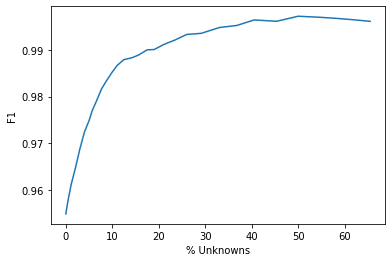

In [31]:
thresh = np.linspace(-2, 3, 50)
x = [100*(1-sum(margin > t)/len(margin)) for t in thresh]
y = [f1_score(test["topics"][margin > t], predicted[margin > t], average="macro") for t in thresh]
plt.plot(x, y)
plt.xlabel('% Unknowns')
plt.ylabel('F1')

In [32]:
print(classification_report(test["topics"][margin > 1.75], predicted[margin > 1.75]))

              precision    recall  f1-score   support

        GJOB       1.00      0.99      0.99       425
        GPOL       0.99      0.99      0.99      1432
        GSPO       1.00      1.00      1.00      1300
        GVIO       0.98      0.98      0.98       621

    accuracy                           0.99      3778
   macro avg       0.99      0.99      0.99      3778
weighted avg       0.99      0.99      0.99      3778



**TO DO:** Summarize your results for this section. What could we do if we wanted to make label as many examples as possible while still keeping F1 above 0.99?

To keep F1 above 0.99, we have to set a thredsold for marginal values. If the margin are too high like 5, the number of examples decreases. But if we lower the number of margin to 1.75, the number of example increases and the F1 score is still 0.99. Therefore, picking the right number for the margin is important in keeping F1 value above 0.99.

---

## Model parameters

In [33]:
coef = sgd.named_steps['sgdclassifier'].coef_
labels, coef

(array(['GJOB', 'GPOL', 'GSPO', 'GVIO'], dtype='<U4'),
 array([[-0.23477751, -0.01556053,  0.13783922, ...,  0.        ,
         -0.00336951,  0.        ],
        [ 0.32468686, -0.11800598, -0.02935398, ...,  0.        ,
          0.        ,  0.00838734],
        [ 0.0923675 ,  0.05184851,  0.03306444, ...,  0.        ,
          0.        ,  0.        ],
        [-0.31918147,  0.        ,  0.0422544 , ...,  0.        ,
          0.        , -0.01313696]]))

In [34]:
coef.shape

(4, 27939)

In [35]:
vocab = sgd.named_steps['countvectorizer'].get_feature_names()

In [36]:
coef[0,:].argmax()

13100

In [37]:
coef[0,13100]

4.516117687624112

In [38]:
vocab[13100]

'jobs'

In [39]:
ranked = np.argsort(coef, axis=1)
for i, label in enumerate(labels):
    print(label)
    for j in concat([range(-1, -11, -1), range(10, 0, -1)]):
        print(f'  {vocab[ranked[i,j]]:15s} {coef[i, ranked[i,j]]:6.3f}')
    print()

GJOB
  jobs             4.516
  strike           4.304
  employees        3.870
  workers          3.704
  unemployment     3.666
  company          2.758
  union            2.647
  unions           2.552
  wages            2.444
  wage             2.410
  welfare         -0.992
  political       -1.041
  parliament      -1.050
  war             -1.076
  clinton         -1.095
  spending        -1.113
  tax             -1.201
  security        -1.291
  budget          -1.373
  election        -1.756

GPOL
  election         3.743
  party            3.145
  elections        2.959
  parliament       2.798
  minister         2.773
  president        2.594
  vote             2.448
  budget           2.170
  clinton          2.077
  yeltsin          1.929
  company         -2.186
  rebels          -2.187
  bombing         -2.238
  strike          -2.487
  unions          -2.566
  employees       -2.591
  soccer          -2.665
  protest         -2.980
  workers         -3.184
  unemployment

In [40]:
from kwic import kwic

In [41]:
kwic('newsroom', train['text'])

4,l Amendment would appear on the state ballot next year. ((-- San Francisco,newsroom,", 415-677-2511))"
5,be called but it need not necessarily result in a work stoppage. -- Warsaw,Newsroom,+48 22 653 9700
14,"0 tonnes) and wheat ship (9,125 tonnes) --Caroline Bulloch, Rio de Janeiro",newsroom,", 5521 5074151"
15,the top tax rate and proposed taxes on night- and holiday shifts. -- Bonn,newsroom,", 49-228-26097150"
21,"t had so far sought to put the new law into effect. --Mark John, Frankfurt",Newsroom,+49 69 756525
37,"p of the conservative New Democracy party. --Dimitris Kontogiannis, Athens",Newsroom,+301 3311812-4
52,saying they would vote compared to 64.6 percent of CSSD voters. -- Prague,Newsroom,42-2-2423-0003
56,nment and a widepread perception that bureaucrats were corrupt. -- Vilnius,newsroom,", +370 2 22 35 17"
76,"on on the person likely to replace Malakis. --George Georgiopoulos, Athens",Newsroom,+301 3311812-4
83,"A promise without a cost is nearly always a lie."" -- Mike Peacock, London",Newsroom,+44 171 542 5109


In [42]:
kwic('zaire', train['text'])

32,rebels assure mining firms of continuity. Rebels on the advance in eastern,Zaire,"will leave mining concessions untouched in the areas they control, provide"
33,"Kabila, Mobutu agree to",Zaire,talks Wednesday - UN. Zaire's beleaguered president Mobutu Sese Seko and r
33,"Kabila, Mobutu agree to Zaire talks Wednesday - UN.",Zaire,'s beleaguered president Mobutu Sese Seko and rebel leader Laurent Kabila h
33,rt of a South African attempt to mediate a peaceful transition of power in,Zaire,. Kabila's rebels now control three quarters of the country and Mobutu has
38,ops who were trapped at the airport and had threatening to rain rockets on,Zaire,"'s second city. A day after the rebel takeover, residents looted army premi"
38,in on from all sides. Disciplined columns of Kabila's forces marched into,Zaire,'s copper capital and economic powerhouse on Wednesday morning. The army la
86,S.Africa to host,Zaire,"government, rebels for talks. Zaire's warring sides have asked President N"
86,"S.Africa to host Zaire government, rebels for talks.",Zaire,'s warring sides have asked President Nelson Mandela of South Africa to hos
86,"s,"" Mandela said. He said South Africa would send air transport to pick up",Zaire,'s rebel leader Laurent Kabila from Kigali in Rwanda and that he hoped the
86,s in Cape Town with regional leaders on how to defuse growing conflicts in,Zaire,"and in southern Africa. Fighting in Zaire has intensified, with ailing Pre"


**TO DO:** What can you conclude about the model from looking at the coefficients? Is there evidence of overfitting? How could we improve the results?

The model has a similar amount of positive and negative coefficient which would balance the predicted values. There are some words that don't belong to the topic which would caused overfitting like soccer in GVIO, security in GJOB, etc. However, these words have a negative indicator which would be subtracted from the predicted value. To improve the model, we could eleminate the words that don't belong to the topic to decrease the overfitting problem. 